In [1]:
# Custom Imports
import sys
sys.path.append("..")
import GradCertModule
import XAIArchitectures
# Deep Learning Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models, transforms
import pytorch_lightning as pl
# Standard Lib Imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#dataset = "pathmnist"
#dataset = "bloodmnist"
#dataset = "retinamnist"
#dataset = "dermamnist"

dataset = "pneumoniamnist"
#dataset = "tissuemnist"

data = np.load('Datasets/%s.npz'%(dataset))


y_train = np.squeeze(data['train_labels'])
y_val = np.squeeze(data['val_labels'])
y_test = np.squeeze(data['test_labels'])


if(dataset in ["pathmnist", "bloodmnist", "retinamnist", "dermamnist"]):
    X_train = np.swapaxes(data['train_images'], 3, 1)/255.0
    X_val = np.swapaxes(data['val_images'], 3, 1)/255.0
    X_test = np.swapaxes(data['test_images'], 3, 1)/255.0
    
elif(dataset in ["tissuemnist", "pneumoniamnist"]):
    X_train = data['train_images']/255.0
    X_train = X_train[0:20000]
    y_train = y_train[0:20000]
    X_train = X_train[:,None]
    X_val = data['val_images']/255.0
    X_val = X_val[0:2000]
    y_val = y_val[0:2000]
    X_val = X_val[:,None]
    X_test = data['test_images']/255.0
    X_test = X_test[:,None]
    
#y_train = torch.nn.functional.one_hot(torch.Tensor(data['train_labels']).to(torch.int64), 10)
#y_val = torch.nn.functional.one_hot(torch.Tensor(data['val_labels']).to(torch.int64), 10)
#y_test = torch.nn.functional.one_hot(torch.Tensor(data['test_labels']).to(torch.int64), 10)

print("train: ", X_train.shape)
print("test: ", X_test.shape)

class custDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X).float()
        self.y = y
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return self.X.shape[0]
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    

CustTrain = custDataset(X_train, y_train)  
CustVal = custDataset(X_val, y_val) 
CustTest = custDataset(X_test, y_test)

class CustomDataModule(pl.LightningDataModule):
    def __init__(self, train, val, test, batch_size=100):
        super().__init__()
        self.train_data = train
        self.val_data = val
        self.test_data = test
        self.batch_size = batch_size
        
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size)
    
dm = CustomDataModule(CustTrain, CustVal, CustTest)

/Users/matthewwicker/opt/anaconda3/envs/FairnessAndPrivacy/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/matthewwicker/opt/anaconda3/envs/FairnessAndPrivacy/lib/python3.7/site-packages/torchvision/image.so, 6): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: /Users/matthewwicker/opt/anaconda3/envs/FairnessAndPrivacy/lib/python3.7/site-packages/torchvision/image.so
  Expected in: /Users/matthewwicker/opt/anaconda3/envs/FairnessAndPrivacy/lib/python3.7/site-packages/torch/lib/libtorch_cpu.dylib
 in /Users/matthewwicker/opt/anaconda3/envs/FairnessAndPrivacy/lib/python3.7/site-packages/torchvision/image.so
  warn(f"Failed to load image Python extension: {e}")


train:  (4708, 1, 28, 28)
test:  (624, 1, 28, 28)


In [2]:
ALPHA = 0.5            # Regularization Parameter (Weights the Reg. Term)
EPSILON = 0.05        # Input Peturbation Budget at Training Time 
# L2 - 0.05
# HESS - 0.025
# PGD - 0.05
# GNORM - 0.025
# GSUMNORM - 0.02
# GRAD - 0.05
GAMMA = 0.00           # Model Peturbation Budget at Training Time 
                        #(Changed to proportional budget rather than absolute)
    
LEARN_RATE = 0.0025      # Learning Rate Hyperparameter
HIDDEN_DIM = 100       # Hidden Neurons Hyperparameter
HIDDEN_LAY = 1         # Hidden Layers Hyperparameter
MAX_EPOCHS = 35

EPSILON_LINEAR = True   # Put Epsilon on a Linear Schedule?
GAMMA_LINEAR = True     # Put Gamma on a Linear Schedule?

In [3]:
#dm = medmnist_dm(batch_size=100, num_workers=0)

if(ALPHA != 0):
    mode = "GRAD"
else:
    mode = "NONE"
if(dataset in ["pathmnist", "bloodmnist", "retinamnist"]):
    model = XAIArchitectures.DeepMindSmall(dataset='MEDMNIST', mode = mode) 
elif(dataset == "tissuemnist"):
    model = XAIArchitectures.DeepMindSmall(dataset='TISSUEMNIST', mode=mode)
elif(dataset == "dermamnist"):
    model = XAIArchitectures.DeepMindSmall(dataset='DERMAMNIST', mode=mode)
else:
    model = XAIArchitectures.FullyConnected(dataset='PNEUMONIAMNIST', mode=mode) 
    #model = XAIArchitectures.(dataset='PNEUMONIAMNIST', mode="GRAD") 

model.set_params(alpha=ALPHA, epsilon=EPSILON, gamma=GAMMA,
                learn_rate=LEARN_RATE, max_epochs=MAX_EPOCHS,
                epsilon_linear=EPSILON_LINEAR,gamma_linear=GAMMA_LINEAR)

#model.inputfooling_ON()

SET MODE TO:  GRAD


In [4]:

trainer = pl.Trainer(max_epochs=MAX_EPOCHS, accelerator="cpu", devices=1)
trainer.fit(model, datamodule=dm)
result = trainer.test(model, datamodule=dm)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | lays | ModuleList | 100 K 
1 | l1   | Linear     | 100 K 
2 | lf   | Linear     | 258   
------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.403     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/matthewwicker/opt/anaconda3/envs/FairnessAndPrivacy/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/Users/matthewwicker/opt/anaconda3/envs/FairnessAndPrivacy/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an check

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/Users/matthewwicker/opt/anaconda3/envs/FairnessAndPrivacy/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8254762291908264
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [5]:


acc = 0
for i in range(len(X_test)):
    d = np.asarray(X_test[i]).reshape(1,28,28)
    out, cls = model.classify(torch.Tensor([d]))
    if(cls == y_test[i]):
        acc += 1
print(acc/len(X_test))


0.8397435897435898


/Users/matthewwicker/opt/anaconda3/envs/FairnessAndPrivacy/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  after removing the cwd from sys.path.


In [6]:

def compute_input_robustness(model, data, target, eps, gam):
    grad = np.squeeze(GradCertModule.InputGrad(model, data.reshape(1,28*28), targ, nclasses=2).detach().numpy())
    model.inputfooling_ON()
    succ, x_adv, grad_adv, targex, loss = GradCertModule.run_mnist_attack(model, data, target=[5,5], epsilon=eps*1.5, 
                                                  iterations=20, lr=0.01, shape=(28,28), label_reg=10.05) 
    model.inputfooling_OFF()
    grad_adv = np.squeeze(GradCertModule.InputGrad(model, x_adv.reshape(28*28), targ, nclasses=2).detach().numpy())

    adv_g = grad_adv
    min_grad, max_grad = GradCertModule.GradCertBounds(model, data.reshape(1,28*28), target, eps, gam, nclasses=2)
    min_grad = np.squeeze(min_grad.detach().numpy())
    max_grad = np.squeeze(max_grad.detach().numpy())
    

    diff_up = max_grad - grad
    diff_down = grad - min_grad
    diff = np.maximum(diff_up, diff_down)
    
    loss_cert = ((diff)**2).mean()
    loss_grad = (((grad - adv_g)/np.max(adv_g))**2).mean()
    
    #plt.imshow(grad.reshape(28,28), cmap='coolwarm')
    #plt.colorbar()
    #plt.show()
    #plt.imshow(adv_g.reshape(28,28), cmap='coolwarm')
    #plt.title(loss_grad)
    #plt.colorbar()
    #plt.show()
    #plt.imshow(np.abs(grad.reshape(28,28) - adv_g.reshape(28,28)), cmap='coolwarm')
    #plt.title(loss_grad)
    #plt.colorbar()
    #plt.show()
    
    return loss_cert, loss_grad

in_cert = 0
in_attk = 0
for inp in range(100):
    data = np.asarray(X_test[inp])
    data = torch.Tensor(data)
    targ = torch.Tensor([y_test[inp]]).to(torch.int64)
    cert, attk = compute_input_robustness(model, data, targ, 0.025, 0.01)
    #print(cert, attk)
    if(cert <= 0.03):
        in_cert += 1
    if(attk <= 0.03):
        in_attk += 1
        
print(in_cert)
print(in_attk)


Loss: 0.041920095682144165: 100%|██████████████| 20/20 [00:00<00:00, 218.92it/s]


100
100


/Users/matthewwicker/opt/anaconda3/envs/FairnessAndPrivacy/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


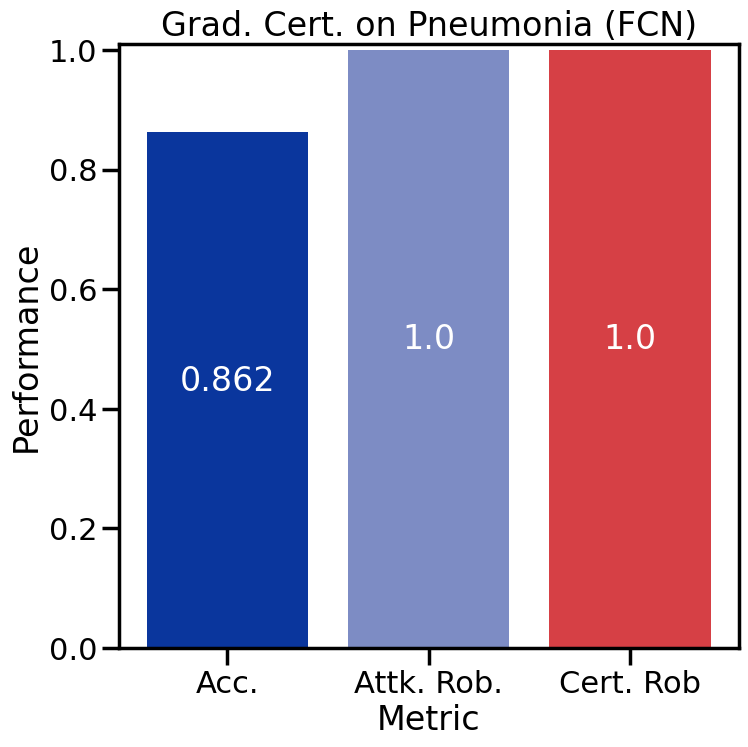

In [10]:
# GSUMNORM - 841, 100, 21
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')
sns.set_context('poster')
plt.figure(figsize=(8, 8), dpi=100)
ax = plt.gca()

dataset = "Pneumonia"
vals = [0.862, 1.00, 1.00]
plt.bar([0,1,2], vals, color=['#0A369D', '#7D8CC4', '#D64045'])
plt.title("Grad. Cert. on %s (FCN)"%(dataset))
plt.ylabel("Performance")
plt.xlabel(r"Metric")

for i in range(3):
    if(i==2):
        plt.text(i, vals[i]/2, vals[i], ha = 'center', c='w')
    else:
        plt.text(i, vals[i]/2, vals[i], ha = 'center', c='w')
        
        
ax.set_xticklabels(['', 'Acc.', 'Attk. Rob.', 'Cert. Rob'])
plt.ylim((0,1.01))
plt.show()
